In [1]:
#Import packages
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import rtree
import fiona
import shapely
from shapely.geometry import Polygon
from shapely.validation import make_valid
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import ee
import geemap
import geemap.foliumap as geemapf
import geetools
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
import affine
import wget
import zipfile
import datetime
import pyinaturalist
from scipy import ndimage
import urllib
import requests
import json
import geojson
import rasterstats
import glob 
import rioxarray
import xarray as xr
import pyogrio
import geocube
from geocube.vector import vectorize
import mapclassify
from pysal.model import spreg
import mgwr
import cmasher as cmr
import pyinaturalist
import mapclassify
import xycmap
from textwrap import fill

Please restart Jupyter kernel after installation if you encounter any errors when importing geemap.
Please restart Jupyter kernel after installation if you encounter any errors when importing geemap.


ImportError: cannot import name 'tarfile' from 'backports' (C:\ProgramData\anaconda3\Lib\site-packages\backports\__init__.py)

In [2]:
pd.options.mode.chained_assignment = None
gpd.options.io_engine='pyogrio'

In [3]:
cd "C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan"

C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan
C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan


In [5]:
# Redefine add_north_arrow from https://github.com/pmdscully/geo_northarrow
def addNarrow(ax, scale=1, xlim_pos=.9, ylim_pos=.8, xT=None, yT=None, color='k', text_scaler=1.0, text_yT=1.0):
    def t_s(xy,xT,yT,s): return (xT+(xy[0]*s),yT+(xy[1]*s))
    def get_default_scale_factor(ax):
        xax_diff = abs(max(ax.get_xlim())-min(ax.get_xlim()))
        yax_diff = abs(max(ax.get_ylim())-min(ax.get_ylim()))
        baseline_lim = 45
        return (sum([xax_diff,yax_diff])/2)/baseline_lim
    def _anchor_pos(_lim, lim_scale): return min(_lim)+(abs(_lim[0]-_lim[1])*lim_scale)
    xT = _anchor_pos(ax.get_xlim(), xlim_pos) if not xT else xT
    yT = _anchor_pos(ax.get_ylim(), ylim_pos) if not yT else yT
    def get_n(scale, text_yT):
        def n_char():
            l = (3.248,5.059,3.248,5.019,3.260,5.019,3.316,5.007,3.339,4.950,3.339,4.479,3.315,4.425,3.260,4.414,3.248,4.414,3.248,4.374,3.423,4.374,3.767,4.904,3.767,4.479,3.743,4.425,3.688,4.414,3.676,4.414,3.676,4.374,3.917,4.374,3.917,4.414,3.904,4.414,3.849,4.426,3.826,4.483,3.826,5.059,3.757,5.059,3.397,4.506,3.397,4.950,3.421,5.007,3.476,5.019,3.489,5.019,3.489,5.059)
            p = []
            t = []
            for i,v in enumerate(l):
                if i%2==0:
                    t += [v]
                elif i%1==0:
                    t += [-v]
                    p += [t]
                    t = []
            return p
        def n_char_TS(points, xTn=0, yTn=0):
            return [ ( (x+xTn) , (y+yTn) ) for (x,y) in points ]
        points = n_char()
        x = np.array(points)[:,0].copy()
        y = np.array(points)[:,1].copy()
        xTn = float((abs(x.max()-x.min())/2)+x.min())
        yTn = float((abs(y.max()-y.min())/2)+y.min())
        pointsZeroed = n_char_TS(points, -xTn, -yTn)
        pointsScaled = [t_s(t,xT=0,yT=0,s=scale) for t in pointsZeroed]
        pointsT = [t_s(t,xT=0,yT=text_yT,s=1) for t in pointsScaled]
        return pointsT
    n_points = get_n(text_scaler, text_yT)
    default_scale = get_default_scale_factor(ax)
    scale = default_scale*scale
    a = [(0, 5), (0, 1), (2, 0)]
    b = [(0, 5), (0, 1), (-2, 0)]
    a = [t_s(t,xT,yT,scale) for t in a]
    b = [t_s(t,xT,yT,scale) for t in b]
    n_points = [t_s(t,xT,yT,scale) for t in n_points]
    p1 = gpd.GeoDataFrame([1], geometry=[Polygon(a)])
    p2 = gpd.GeoDataFrame([1], geometry=[Polygon(b)])
    p3 = gpd.GeoDataFrame([1], geometry=[Polygon(n_points)])
    ax = p1.plot(fc='none', ec=color, lw=1, ax=ax)
    p2.plot(fc=color, ec=color, lw=1, ax=ax)
    p3.plot(fc=color, ax=ax)

In [6]:
CRW=gpd.read_file("../../Raw_Data/CRW_Boundary/CRW_Boundary/CRW_Boundary.shp")
towns=gpd.read_file("../../Raw_Data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp").to_crs(CRW.crs).clip(CRW)
rivers=gpd.read_file('../../Raw_Data/Hydro/HYDRO25K_POLY.shp').clip(CRW)
Charles=rivers[rivers['NAME']=='Charles River'].to_crs(epsg=26986)
Tribs=gpd.read_file('../../Raw_Data/Rivers/Tributaries.shp')
CHARLES=Tribs[Tribs.SARISNAME=='CHARLES RIVER']

# Parcel-wise Tree Canopy

In [ ]:
# I clipped this in ArcGIS because was so large and had to combine east and west
Parcels=gpd.read_file('../../Working_Data/ParcelsClipped_fromstate.shp')

<IPython.core.display.HTML object>

In [ ]:
public=pd.read_csv('../../Working_Data/ParcelsUseCodes_CONVERTER.csv')
Parcels_wPublic=Parcels.merge(public, on='USE_CODE')

<IPython.core.display.HTML object>

In [ ]:
bad_geos_indexes=Parcels_wPublic[~Parcels_wPublic.geometry.is_valid].index
for i in bad_geos_indexes:
    Parcels_wPublic.loc[i,'geometry']=make_valid(Parcels_wPublic.geometry[i])

<IPython.core.display.HTML object>

In [ ]:
CRW=gpd.read_file("../../Raw_Data/CRW_Boundary/CRW_Boundary/CRW_Boundary.shp")
rivers=gpd.read_file('../../Raw_Data/Hydro/HYDRO25K_POLY.shp').clip(CRW)

<IPython.core.display.HTML object>

In [ ]:
missing=CRW.dissolve().overlay(Parcels_wPublic.dissolve(),how='difference').overlay(rivers.dissolve(),how='difference').dissolve()

<IPython.core.display.HTML object>

In [ ]:
fix=Parcels_wPublic[Parcels_wPublic.Public=='X'].dissolve().overlay(missing,how='union',keep_geom_type=True).dissolve().geometry

<IPython.core.display.HTML object>

In [ ]:
Par=Parcels_wPublic[Parcels_wPublic.Public!='X']
Par=pd.concat([Par, fix])
bad_geos_indexes=Par[~Par.geometry.is_valid].index
for i in bad_geos_indexes:
    Par.loc[i,'geometry']=make_valid(Par.geometry[i])
Par=Par.reset_index(drop=True)
Par.loc[291814,'MAP_PAR_ID']='Missing'

<IPython.core.display.HTML object>

In [28]:
ParStats=pd.DataFrame(rasterstats.zonal_stats(Par, "../../Working_Data/TCC"+'2021'+".tif",stats="mean median percentile"),index=Par.index)

<IPython.core.display.HTML object>

In [30]:
ParStats.to_csv('../../Working_Data/ParcelStats.csv')

<IPython.core.display.HTML object>

In [11]:
ParStats=pd.read_csv('../../Working_Data/ParcelStats.csv')

<IPython.core.display.HTML object>

In [12]:
ParTree=Par.join(ParStats)

<IPython.core.display.HTML object>

In [12]:
ParTree.rename(index=str,columns={'mean':'meanTCC2021','median':'medianTCC2021'},inplace=True)

<IPython.core.display.HTML object>

In [14]:
ParTree.to_file('../../Working_Data/Parcels with TCC.shp')

<IPython.core.display.HTML object>

<positron-console-cell-14>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


# What parcels are in the HP zones and how much TCC do they have?

In [7]:
ParTree=gpd.read_file('../../Working_Data/Parcels with TCC.shp')

<IPython.core.display.HTML object>

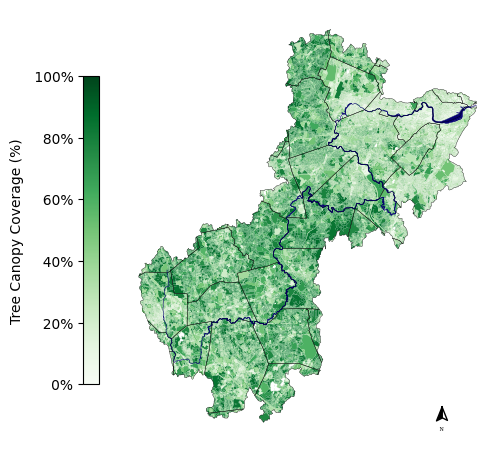

In [7]:
# Plot 2021 tree canopy coverage
f, ax = plt.subplots(figsize=(6,8))
ParTree.plot(ax=ax,column='meanTCC202',cmap='Greens',legend=True,vmin=0,vmax=100,legend_kwds={'orientation':'vertical','location':'left',
                                                                                        'shrink':0.5,'aspect':20,
                                                                                        'pad':0.05,'format':"%4i%%",
                                                                                        'label':'Tree Canopy Coverage (%)'})
towns.to_crs(epsg=26986).boundary.plot(ax=ax, color='black',linewidth=0.25)
Charles.plot(ax=ax,color='#060270',edgecolor='#060270',linewidth=0.25)
CHARLES.to_crs(epsg=26986).plot(ax=ax,color='#060270',linewidth=0.4)

#cbar=f.colorbar(hidden, cmap=my_greens,orientation='vertical',location='left',
#                shrink=0.5,aspect=20,pad=0.05,format="%4i%%",label='Tree Canopy Coverage (%)')
#cbar.ax.tick_params(labelsize=16)
#cbar.set_label(label='Tree Canopy Coverage (2021)',fontsize=16)

ax.axis('off')

# Scalebar and north arrow
addNarrow(ax=ax,scale=0.32,ylim_pos=0.05,xlim_pos=0.86,text_scaler=2, text_yT=-3)
ax.add_artist(ScaleBar(1,location='lower left',bbox_to_anchor=(1370,40),height_fraction=0.005,font_properties={'size':6},box_alpha=0))

f.savefig('Output Maps/2021 parcels w TCC.png',transparent=True,dpi=300,bbox_inches='tight')

In [8]:
# Load conservation priority data
cons_opps=gpd.read_file('../../Raw_Data/TNC_Cons/High Level Conservation Opp/High Priority Conservation Opportunities/High Priority Conservation Opportunities.shp').to_crs(epsg=26986)

<IPython.core.display.HTML object>

In [22]:
# Subset to only high priority conservation opportunities
HP_cons_opps=cons_opps[cons_opps.Priority=='High Priority']
Protect_All=gpd.read_file('../../Working_Data/Protect All Areas.geojson')
HP_cons=HP_cons_opps.overlay(Protect_All.dissolve(),how='difference').dissolve()
HP_cons.to_file('../../Working_Data/HP Conservation Opps not Protected.shp')

<IPython.core.display.HTML object>

In [9]:
#ParTree.clip(HP_cons)
HP_Par=gpd.read_file('../../Working_Data/Parcels with TCC clipped to HP unprotected.shp')

<IPython.core.display.HTML object>

In [10]:
HP_Par.columns

<IPython.core.display.HTML object>


Index(['index', 'MAP_PAR_ID', 'LOC_ID', 'POLY_TYPE', 'MAP_NO', 'SOURCE', 'PLAN_ID', 'LAST_EDIT',
       'BND_CHK', 'NO_MATCH', 'TOWN_ID', 'PROP_ID', 'BLDG_VAL', 'LAND_VAL', 'OTHER_VAL', 'TOTAL_VAL',
       'FY', 'LOT_SIZE', 'LS_DATE', 'LS_PRICE', 'USE_CODE', 'SITE_ADDR', 'ADDR_NUM', 'FULL_STR',
       'LOCATION', 'CITY', 'ZIP', 'OWNER1', 'OWN_ADDR', 'OWN_CITY', 'OWN_STATE', 'OWN_ZIP', 'OWN_CO',
       'LS_BOOK', 'LS_PAGE', 'REG_ID', 'ZONING', 'YEAR_BUILT', 'BLD_AREA', 'UNITS', 'RES_AREA', 'STYLE',
       'NUM_ROOMS', 'LOT_UNITS', 'STORIES', 'SHAPE_Leng', 'Shape_Le_1', 'Shape_Area', 'Public',
       'Unnamed__0', 'meanTCC202', 'medianTCC2', 'geometry'],
      dtype='object')

<IPython.core.display.HTML object>

<Axes: xlabel='Shape_Area', ylabel='meanTCC202'>

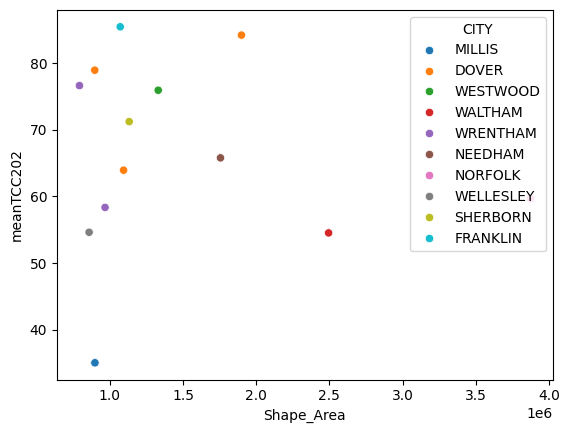

In [11]:
med=HP_Par.Shape_Area.quantile(q=0.98)
top=HP_Par[HP_Par.Shape_Area>med]
sns.scatterplot(top,x='Shape_Area',y='meanTCC202',hue='CITY',legend=True)

<IPython.core.display.HTML object>

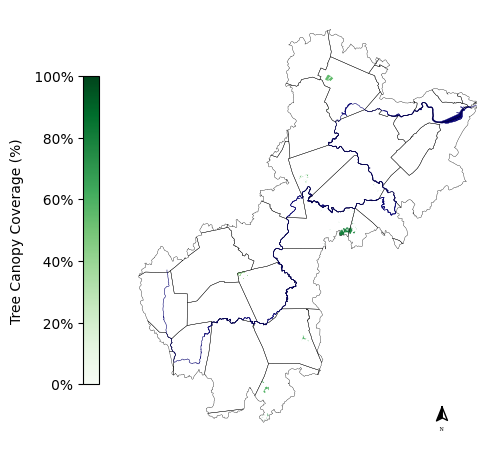

In [12]:
# Plot 2021 tree canopy coverage
f, ax = plt.subplots(figsize=(6,8))
top.plot(ax=ax,column='meanTCC202',cmap='Greens',legend=True,vmin=0,vmax=100,legend_kwds={'orientation':'vertical','location':'left',
                                                                                        'shrink':0.5,'aspect':20,
                                                                                        'pad':0.05,'format':"%4i%%",
                                                                                        'label':'Tree Canopy Coverage (%)'})
towns.to_crs(epsg=26986).boundary.plot(ax=ax, color='black',linewidth=0.25)
Charles.plot(ax=ax,color='#060270',edgecolor='#060270',linewidth=0.25)
CHARLES.to_crs(epsg=26986).plot(ax=ax,color='#060270',linewidth=0.4)

#cbar=f.colorbar(hidden, cmap=my_greens,orientation='vertical',location='left',
#                shrink=0.5,aspect=20,pad=0.05,format="%4i%%",label='Tree Canopy Coverage (%)')
#cbar.ax.tick_params(labelsize=16)
#cbar.set_label(label='Tree Canopy Coverage (2021)',fontsize=16)

ax.axis('off')

# Scalebar and north arrow
addNarrow(ax=ax,scale=0.32,ylim_pos=0.05,xlim_pos=0.86,text_scaler=2, text_yT=-3)
ax.add_artist(ScaleBar(1,location='lower left',bbox_to_anchor=(1370,40),height_fraction=0.005,font_properties={'size':6},box_alpha=0))

f.savefig('Output Maps/top 98 percentile 2021 parcels w TCC.png',transparent=True,dpi=300,bbox_inches='tight')

In [13]:
top.to_csv('../../Working_Data/98 percentile candidates for protection.csv')

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<Axes: >

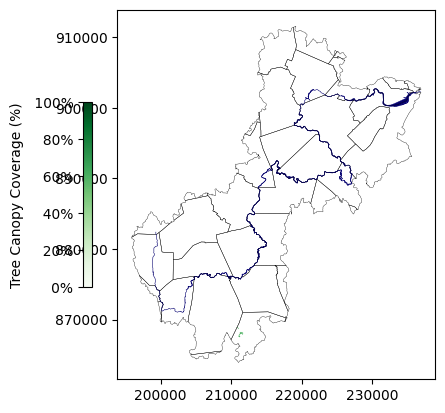

In [90]:
test=top[top.OWNER1=='BIRD INCORPORATED']
ax=test.plot(column='meanTCC202',cmap='Greens',legend=True,vmin=0,vmax=100,legend_kwds={'orientation':'vertical','location':'left',
                                                                                        'shrink':0.5,'aspect':20,
                                                                                        'pad':0.05,'format':"%4i%%",
                                                                                        'label':'Tree Canopy Coverage (%)'})
towns.to_crs(epsg=26986).boundary.plot(ax=ax, color='black',linewidth=0.25)
Charles.plot(ax=ax,color='#060270',edgecolor='#060270',linewidth=0.25)
CHARLES.to_crs(epsg=26986).plot(ax=ax,color='#060270',linewidth=0.4)

# How many nurseries are in the watershed

In [14]:
ParTree[ParTree.USE_CODE=='719']

,index,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,NO_MATCH,TOWN_ID,PROP_ID,BLDG_VAL,LAND_VAL,OTHER_VAL,TOTAL_VAL,FY,LOT_SIZE,LS_DATE,LS_PRICE,USE_CODE,SITE_ADDR,ADDR_NUM,FULL_STR,LOCATION,CITY,ZIP,OWNER1,OWN_ADDR,OWN_CITY,OWN_STATE,OWN_ZIP,OWN_CO,LS_BOOK,LS_PAGE,REG_ID,ZONING,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,NUM_ROOMS,LOT_UNITS,STORIES,SHAPE_Leng,Shape_Le_1,Shape_Area,Public,Unnamed_ 0,meanTCC202,medianTCC2,geometry
236443,236443,70-00000005,F_707224_2920351,FEE,70,ASSESS,None,20111212.0,None,N,198.0,70-00000005,2328000.0,749300.0,482850.0,3077300.0,2024.0,47.0,20050721,4700000.0,719,89 PLEASANT ST,89,PLEASANT ST,None,NATICK,01760,LOOKOUT FARM LLC,89 PLEASANT ST S,NATICK,MA,01760,None,45668,465,None,RSB,1960.0,5336.0,1.0,0.0,None,0.0,Acres,None,30557.56787,2607.18511,191726.652417,R,236443,16.851163,13.0,"POLYGON ((215827.422 890287.624, 215847.656 89..."
